# Lecture 13: Introduction to Regression

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture13.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8.  
 
- code taken and modified from 
[astroML figure 8.6](http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html)
 

<a id='toc'></a>

## This notebook includes:

[Ordinary least square method](#ordinaryLSQ)

[Total least square method](#totalLSQ) 

[Linear Basis Function Regression](#basis) 

[Non-linear Regression with MCMC](#mcmc) 

## Ordinary least square method <a id='ordinaryLSQ'></a>
[Go to top](#toc)

In [19]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib
matplotlib.rc('text', usetex=False)
import seaborn as sns
from scipy import optimize

from astroML.linear_model import TLS_logL
from astroML.datasets import fetch_vega_spectrum
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

In [2]:
# We'll use the data from table 1 of Hogg et al. 2010
from astroML.datasets import fetch_hogg2010test  
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, discussed later)
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']
y_obs = y

(100.0, 600.0)

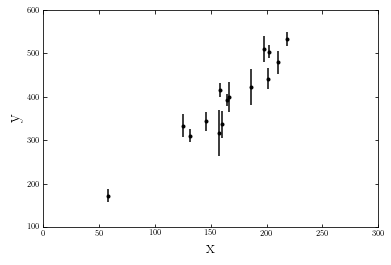

In [3]:
# Plot the data with y error bars
plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0) 
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.xlim(0, 300)
plt.ylim(100, 600)

#### We have data $y(x)$ and we want to fit this model (i.e. we want to obtain m and b):

$$\mathbf{y} = m \, \mathbf{x} + b$$


For this problem the maximum likelihood and full posterior probability distribution (under infinitely broad priors) for the slope and intercept of the line are known analytically. The analytic result for the posterior probability distribution is a 2-d Gaussian with mean

$$\mathbf{w} = \left(\begin{array}{c}
    m \\ b
\end{array}\right) = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1} \, \mathbf{A}^\mathrm{T}\,C^{-1}\,\mathbf{y}$$

and covariance matrix

$$\mathbf{V} = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1}$$

where

$$\mathbf{y} = \left(\begin{array}{c}
y_1 \\ y_2 \\ \vdots \\ y_N
\end{array}\right) \quad , \quad \mathbf{A} = \left(\begin{array}{cc}
x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1
\end{array}\right) \quad ,\, \mathrm{and} \quad
\mathbf{C} = \left(\begin{array}{cccc}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
&&\ddots& \\
0 & 0 & \cdots & \sigma_N^2
\end{array}\right)$$

There are various functions in Python for computing this but let's do it explicitly and step by step. With numpy, it only takes a few lines of code  - here it is:

In [4]:
A = np.vander(x, 2)  # Take a look at the documentation to see what this function does!
                     # https://numpy.org/doc/stable/reference/generated/numpy.vander.html
ATA = np.dot(A.T, A / sigma_y[:, None]**2)
w = np.linalg.solve(ATA, np.dot(A.T, y / sigma_y**2))
V = np.linalg.inv(ATA)

Let's take a look and see what this prediction looks like. 

To do this, we'll sample 99 slopes and intercepts from this 2-D Gaussian and overplot them on the data.

Text(0, 0.5, 'y')

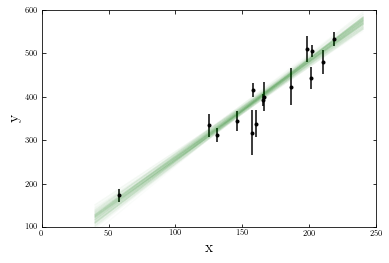

In [5]:
plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0)
xGrid = np.linspace(40, 240)
# note that we are drawing 99 lines here, with m and b randomly sampled from w and V 
for m, b in np.random.multivariate_normal(w, V, size=99):
    plt.plot(xGrid, m*xGrid + b, "g", alpha=0.02)
plt.xlim(0, 250)
plt.ylim(100, 600)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

Text(0, 0.5, 'b')

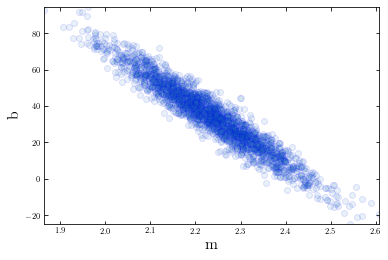

In [6]:
# let's visualize the covariance between m and b
a = np.random.multivariate_normal(w, V, size=2400)
plt.scatter(a[:,0], a[:,1], alpha=0.1)
plt.xlabel('m', fontsize=16)
plt.ylabel('b', fontsize=16) 

### Another approach: the probabilistic model

In order to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. For reasons that will become clear below, we actually only need to return a value that is *proportional* to the probability.

As discussed in a previous tutorial, the posterior probability for parameters $\mathbf{w} = (m,\,b)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the datapoints are independent with known Gaussian uncertainties $\sigma_n$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_n^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_n^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model.

For numerical reasons, we will acutally want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_n^2} + \mathrm{constant} \quad.$$

By maxmizing $p(\mathbf{y} \,|\, \mathbf{w})$, we obtain posterior probability distributions for $m$ and $b$.

##  "Total Least Squares" regression <a id='totalLSQ'></a>
[Go to top](#toc)

or
### LSQ with uncertainties in both the dependent and independent axes 

In almost all real-world applications, the assumption that one
variable (the independent variable) is essentially free
from any uncertainty is not valid. Both the dependent and independent
variables will have measurement uncertainties.

The impact of errors on the ``independent'' variables is a bias in the
derived regression coefficients. This is straightforward to show if
we consider a linear model with a dependent and independent
variable, $y^*$ and $x^*$. We can write the objective function as
before,

\begin{equation}
y^*_i=\theta_0 + \theta_1x^*_{i}.
\end{equation}

Now let us assume that we observe
$y$ and $x$, which are noisy
representations of $y^*$ and $x^*$, i.e.,
\begin{eqnarray}
x_i&=&x^*_i + \delta_i,\\
y_i &=& y^* + \epsilon_i,
\end{eqnarray}
with $\delta$ and $\epsilon$ centered normal distributions.

Solving for $y$ we get
\begin{equation}
      y=  \theta_0 + \theta_1 (x_i - \delta_i) +\epsilon_i.
\end{equation}

The uncertainty in $x$ is now part of the regression equation and
scales with the regression coefficients (biasing the regression
coefficient).  This problem is known in the statistics literature
as *total least squares* and belongs to the class of ``errors-in-variables''
problems.


For a detailed discussion of the solution to this problem, which is essentially
maximum likelihood estimation, please see
Chapter 8 in the reference book. Two other recommended references are
Hogg et al. (2010, astro-ph/1008.4686) and Kelly et al. (2011, astro-ph/1112.1745).

Let's now play with the data! 

In [7]:
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse principal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))
        
# Find best-fit parameters
def get_best_fit(x, y, sigma_x, sigma_y, rho_xy):
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

    # note: TLS_logL was imported from astroML.linear_model 
    min_func = lambda beta: -TLS_logL(beta, X, dX)
    # this is optimization, not MCMC
    return optimize.fmin(min_func, x0=[-1, 1])


# plot results 
def plot_best_fit(x, y, sigma_x, sigma_y, rho_xy, beta_fit, mLSQ, bLSQ):
    fig = plt.figure(figsize=(8, 5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)
    ax = fig.add_subplot(121)
    ax.scatter(x, y, c='k', s=9)
    plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)
    
    # plot the best-fit line
    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(0, 300, 10)
    ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')
    ax.plot(x_fit, mLSQ * x_fit + bLSQ, '--', c='red')

    ax.set_xlim(40, 250)
    ax.set_ylim(100, 600)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    # plot the likelihood contour in m, b
    ax = fig.add_subplot(122)
    m = np.linspace(1.7, 2.8, 100)
    b = np.linspace(-60, 110, 100)
    logL = np.zeros((len(m), len(b)))

    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y
    for i in range(len(m)):
        for j in range(len(b)):
            logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

    ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997), colors='k')
    ax.plot([-1000, 1000], [bLSQ, bLSQ], ':k', lw=1, c='red')
    ax.plot([mLSQ, mLSQ], [-1000, 1000], ':k', lw=1, c='red')

    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.set_xlim(1.7, 2.8)
    ax.set_ylim(-60, 110)

    plt.show()

In [8]:
# for comparison, let's get the standard LSQ solution
mux = np.mean(x)
muy = np.mean(y)
mLSQ = np.sum(x*y-mux*muy)/np.sum((x-mux)**2)
bLSQ = muy - mLSQ*mux
print('mLSQ=', mLSQ)
print('bLSQ=', bLSQ)

mLSQ= 2.191027996426704
bLSQ= 32.00396939102313


Optimization terminated successfully.
         Current function value: 56.688229
         Iterations: 85
         Function evaluations: 160
m= 2.299303276704902
b= 24.151505990843706


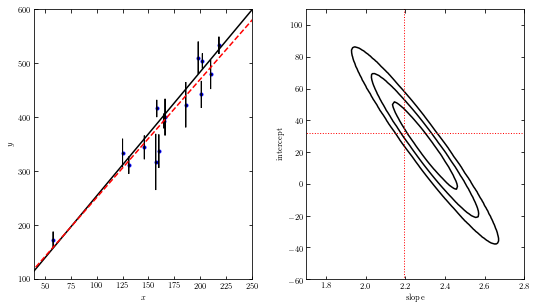

In [9]:
## let's do only errors in y - this is standard LSQ 
# Find best-fit parameters
err_x = 0*sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit1 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit1, b_fit1 = get_m_b(best_fit1)
print('m=', m_fit1)
print('b=', b_fit1)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit1, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 72.220549
         Iterations: 171
         Function evaluations: 318
m= 2.596107117541477
b= -43.9768263126515


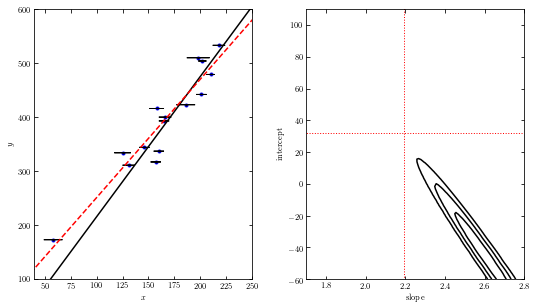

In [10]:
## now only errors in x; note that we could switch the axes and use standard LSQ
# Find best-fit parameters
err_x = sigma_x
err_y = 0*sigma_y
rho = rho_xy
best_fit2 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit2, b_fit2 = get_m_b(best_fit2)
print('m=', m_fit2)
print('b=', b_fit2)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit2, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 56.630031
         Iterations: 71
         Function evaluations: 136
m= 2.3849344880407286
b= 6.042234007073399


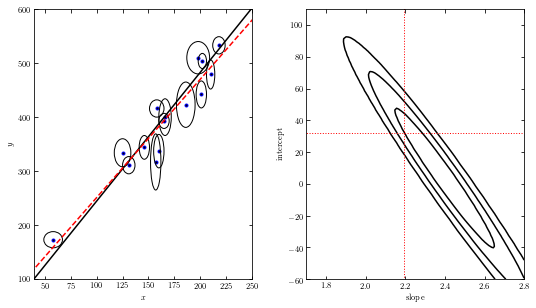

In [11]:
## errors in x and y, but without covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit3 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit3, b_fit3 = get_m_b(best_fit3)
print('m=', m_fit3)
print('b=', b_fit3)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit3, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164
m= 2.248785375229947
b= 27.930434942133815


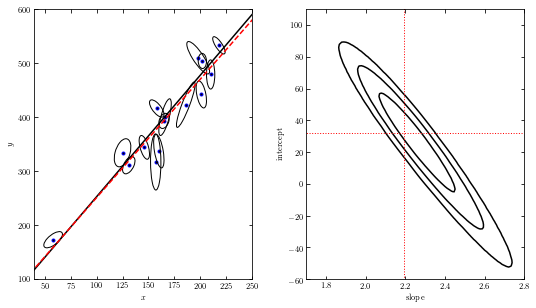

In [12]:
## errors in x and y with covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = rho_xy
best_fit4 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit4, b_fit4 = get_m_b(best_fit4)
print('m=', m_fit4)
print('b=', b_fit4)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit4, mLSQ, bLSQ)

In [13]:
# compare all 4 versions and LSQ
print('m=', m_fit1, m_fit2, m_fit3, m_fit4, mLSQ)

m= 2.299303276704902 2.596107117541477 2.3849344880407286 2.248785375229947 2.191027996426704


### CONCLUSION

Beware of your measurement uncertainties, especially if both variables have them!

##### Markov Chain Monte Carlo (MCMC) method allows you to solve non-linear problems, too! 
but we cannot cover everything in only a few hours...
 

## Linear Basis Function Regression <a id='basis'></a>
[Go to top](#toc)

We don't have to use only polynomials ($x$, $x^2$, $x^3$, etc) - we can use any function f(x)
and still have a linear problem (in unknown coefficients, $a_i$), e.g.

$$  y(x) = \sum_i^N a_i \, f_i(x) $$

### Example: 

Let's express a complicated $y(x)$, such a spectrum of Vega, as sum of 
Gaussian functions: $ f_i(x) = N(x|\mu_i, \sigma)$, where $\mu_i$ are defined on a grid and $\sigma$ is constant and chosen depending on the intrinsic problem resolution.

Why? Because then we can do convolution with another function (which can be also expressed
as a series of Gaussian functions) analytically! 

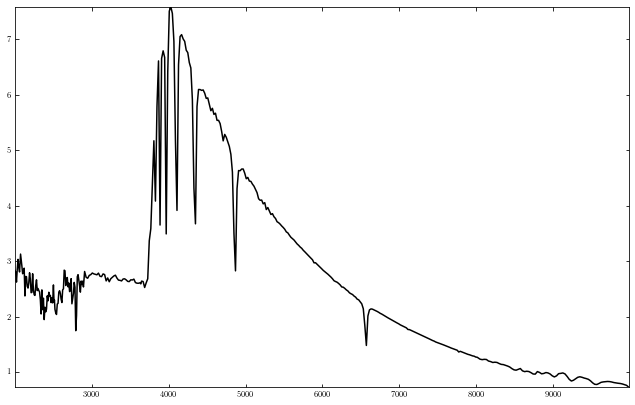

In [14]:
from astroML.datasets import fetch_vega_spectrum
# Fetch the data
x, y = fetch_vega_spectrum()
# truncate the spectrum
mask = (x >= 2000) & (x < 10000)
x = x[mask]
y = y[mask]*1.0e14

# a quick plot 
plt.figure(figsize=(11, 7))
plt.plot(x, y, '-k', label='input spectrum')
plt.show()

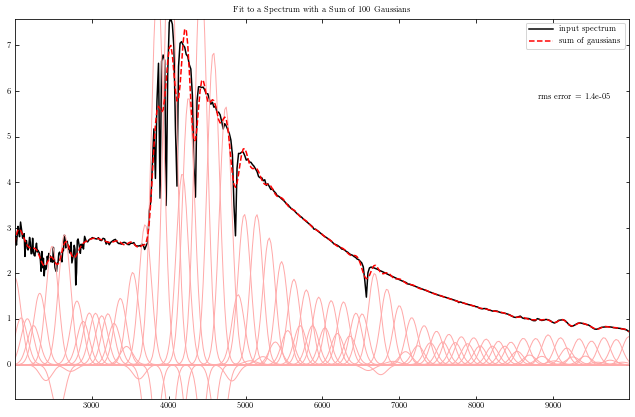

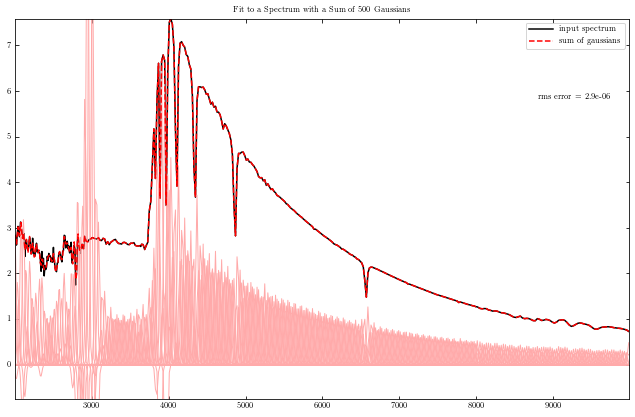

In [15]:
from astroML.sum_of_norms import sum_of_norms, norm
for n_gaussians in (100, 500):

    # compute the best-fit linear combination
    # the actual astroML code cab be found in file 
    #    $astroMLdir/astroML/sum_of_norms.py
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results
    plt.figure(figsize=(11, 7))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()


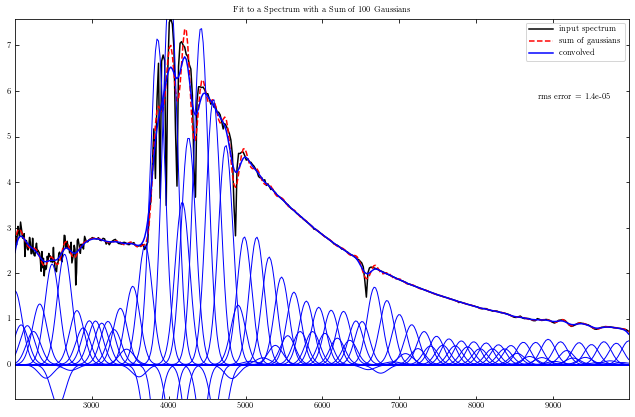

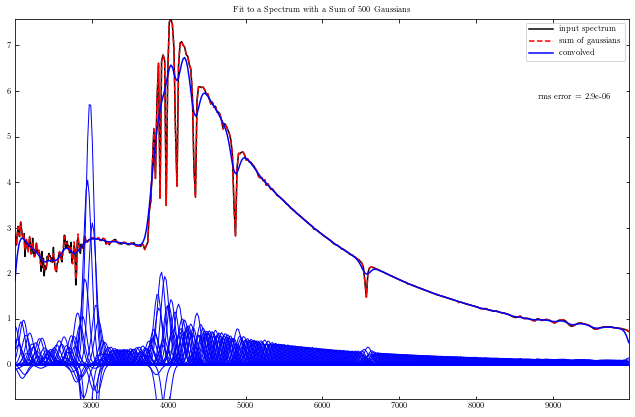

In [16]:
for n_gaussians in (100, 500):

    # compute the best-fit linear combination
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results
    plt.figure(figsize=(11, 7))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    # plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    
    # convolve with a gaussian instrumental resolution (width = 50)
    widths2 = np.sqrt(widths**2 + 50**2)
    norms2 = w_best * norm(x[:, None], locs, widths2)
    plt.plot(x, norms2, ls='-', c='blue', lw=1)
    plt.plot(x, norms2.sum(1), '-b', label='convolved')

    
    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()


##  Non-linear Regression with MCMC<a id='mcmc'></a>
[Go to top](#toc)

### Here MCMC stands for Markov Chain Monte Carlo

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps are included, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing chains, including the Metropolis–Hastings algorithm. For more details,
see Chapter 5 in the textbook and 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

**To find the maximum of a multi-dimensional function (e.g. likelihood or Bayesian posterior pdf)
we need a better method than the brute force grid search!**

For example, if we could generate a **sample** of  {𝜇𝑖,𝜎𝑖}  drawn from the posterior pdf for  𝜇  and  𝜎 , we could simply get posterior pdf for  𝜇  and  𝜎  by plotting histograms of  𝜇  and  𝜎  (similar to the above figure). As simple as that!

But how can we get such samples? **By using computers!** And MCMC :)

First we'll say a few words about Monte Carlo in general, and then we'll talk about a special kind of Monte Carlo called Markov Chain Monte Carlo.

### Definition of the general problem

What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 
$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$
where for simplicity posterior pdf is described as
$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: here $g(\theta) = 1$ and we integrate over all model
parameters. 

## Monte Carlo Methods 

What you need is a computer that can generate (pseudo)random numbers and then you
solve a lot of hard problems. Let' start with an easy problem of one-dimensional
numerical integration.

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled 
within the integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

##  Markov Chain Monte Carlo

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.


### Example of non-linear regression: the age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper "An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf

Given their y(x) data (see below), with errors in both x and y, we want to fit the following function

$$ 𝑦(𝑥)=𝑎+𝑏∗[1−𝑒𝑥𝑝(−(𝑥/𝑐)^𝑑)]. $$

We have a case of non-linear regression because y(x) depends non-linearly on the 
unknown coefficients c and d.
 
Important: here x is time, not log(time)! But in plots we'll use log(time) for x axis.

We want to: 

a) find the best-fit values and standard errors for parameters a, b, c and d. 

b) show the marginal distributions of fitted parameters. 

c) compare our best fit to the best fit from Jedicke et al.  


In [17]:
# These age and color data for asteroid families are taken
# from the paper Jedicke et al. (2004, Nature 429, 275) 

# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)

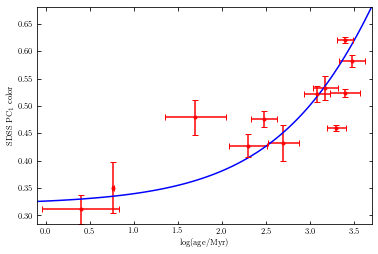

In [18]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show() 

#### We will use pymc3 as the tool of choice to perform MCMC, see
[pymc3 docs](https://docs.pymc.io/)


I highly recommend to peruse this 
[excellent blog post by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)


In [20]:
import pymc3 as pm
from astroML.plotting.mcmc import plot_mcmc 

In [21]:
# to make it look more generic (for future code reuse)
xObs = age
xErr = ageErr
yObs = PC1
yErr = PC1err

In [30]:
# three points to make:
# 1) note setting of the priors (for a, b, c and d)
# 2) note how error in x is handled with a latent variable
# 3) the actual model that is fit is given by AgeColor()
#      and it's super easy to change it! 
def MCMCasteroids(doXerror=True, draws=10000, tune=1000):
    with pm.Model():
        a = pm.Uniform('a', 0.1, 0.5)
        b = pm.Uniform('b', 0, 10)
        c = pm.Uniform('c', 0, 2000000)
        d = pm.Uniform('d', 0, 2)

        if doXerror:
            xLatent = pm.Normal('x', mu=xObs, sd=xErr, shape=xObs.shape)  
        else:
            xLatent = xObs
 
        y = pm.Normal('y', mu=AgeColor(xLatent, a, b, c, d), sd=yErr, observed=yObs)
        traces = pm.sample(draws=draws, tune=tune, return_inferencedata=False)

        return traces
    
# model to fit 
def AgeColor(t, a, b, c, d):
    """age-color relationship from Jedicke et al. (2004)"""
    return a + b*(1-np.exp(-(t/c)**d))

In [31]:
# obtain best-fit parameters using MCMC
traces = MCMCasteroids(True)
bf = pm.summary(traces)['mean']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, d, c, b, a]
Sampling 4 chains: 100%|██████████| 44000/44000 [07:49<00:00, 93.75draws/s] 
There were 5618 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6217 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6098 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8878700176239559, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


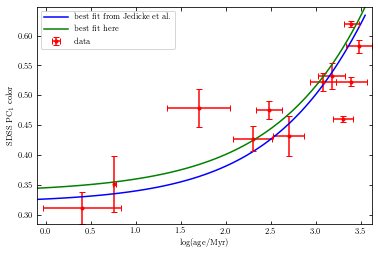

In [32]:
# let's take a look at the data and best-fit models 
logT = np.linspace(-0.1, 3.55, 100)
time = np.power(10,logT)

# fit from Jedicke
colorJedicke = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
colorHere = AgeColor(time, bf['a'], bf['b'], bf['c'], bf['d']) 

# plot 
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,colorJedicke, c='blue', label='best fit from Jedicke et al.')
ax.plot(logT,colorHere, c='green', label='best fit here')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', marker='.', ls='None', label='data')
plt.legend()
plt.show() 

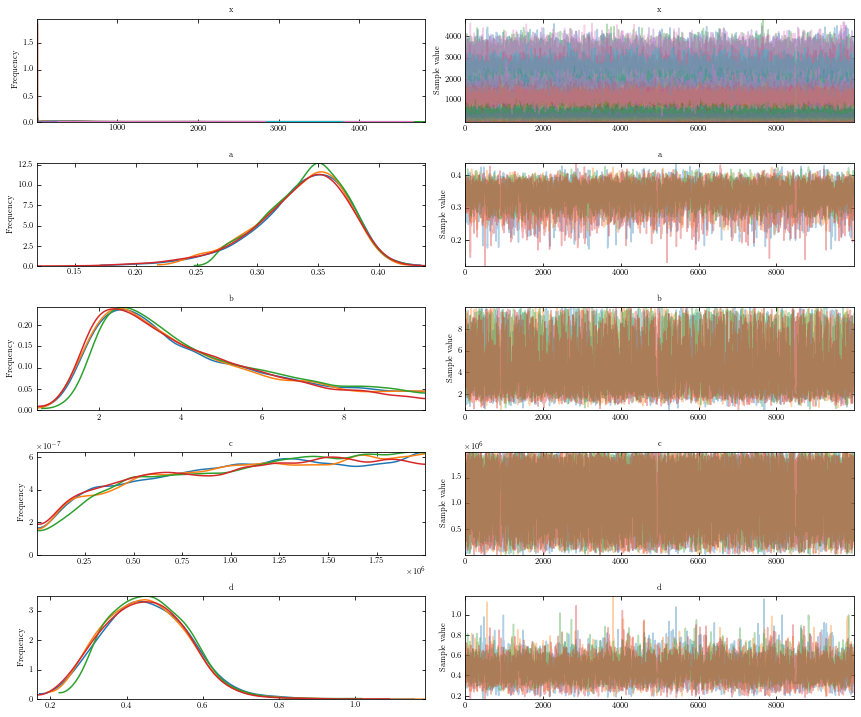

In [33]:
# the so-called traces for model parameters:
plot = pm.traceplot(traces)

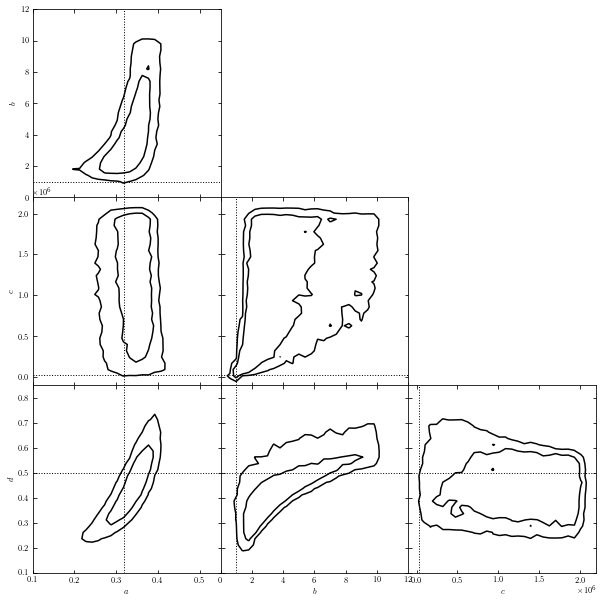

In [34]:
# and a pretty so-called corner plot:
labels = ['$a$', '$b$', '$c$', '$d$']
limits = [(0.1, 0.55), (0.0, 12), (-100000,2200000), (0.1, 0.85)]
jedicke = [0.32, 1.0, 25000, 0.5]


# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['a', 'b', 'c', 'd']],
          labels=labels, limits=limits,
          true_values=jedicke, fig=fig, bins=30, colors='k')

plt.show()

In [39]:
import corner

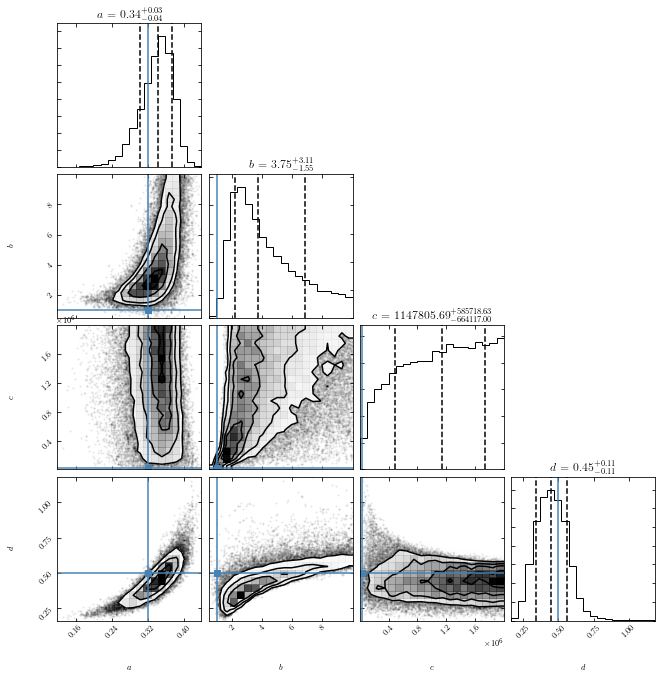

In [56]:
Ls = [r"$a$", r"$b$", r"$c$", r"$d$"] 
samples = np.vstack([traces[i] for i in ['a', 'b', 'c', 'd']]).T
corner.corner(samples, truths=jedicke, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

### Instead of using pymc3, we will solve a similar problem with much more light-weight emcee tool during our afternoon activity later today

In [72]:
import emcee